# Deep Ensemble Comparison: Old vs New Stacking

**Objective**: Systematically compare old vs new ensemble across multiple dimensions:
- Different hyperparameter configurations with varying complexity levels
- Cross-validation strategies (3, 5, 7, 10 folds)
- Meta-classifier hyperparameter tuning
- Multiple datasets and training sizes

**Key Hypotheses to Test**:
1. New ensemble should outperform old when overfitting is a concern (complex models)
2. More CV folds should improve new ensemble performance
3. Proper hyperparameter tuning reveals the true advantage of clean CV

**Methodology**:
- Test minimal, balanced, and complex hyperparameter configurations
- Vary CV folds systematically for new ensemble
- Tune meta-classifier parameters based on feature count
- Measure both accuracy and class-balanced metrics

In [1]:
# DEEP COMPARISON CONFIGURATION
DATASET_NAME = "Pedestrian"  # Can test with: "Coffee", "Beef", "Rock", "FaceFour"
TRAIN_PCT = 5.0             # Increased for better hyperparameter testing
TEST_PCT = 10.0              
RANDOM_SEED = 42             

# Systematic hyperparameter exploration
CONFIGS = {
    # Test overfitting resistance with minimal complexity
    "minimal": {
        "hydra_k": 2,
        "hydra_g": 8,
        "quant_depth": 4,
        "quant_div": 2,
        "n_estimators": 25,  # For old ensemble
        "meta_n_estimators": 50,  # For new ensemble meta-classifier
        "meta_max_features": 0.3,
        "cv_folds_to_test": [3, 5]  # Test different CV strategies
    },
    
    # Balanced configuration - should work well for both
    "balanced": {
        "hydra_k": 8,
        "hydra_g": 64,
        "quant_depth": 6,
        "quant_div": 4,
        "n_estimators": 100,
        "meta_n_estimators": 100,
        "meta_max_features": 0.1,
        "cv_folds_to_test": [3, 5, 7]
    },
    
    # Complex configuration - where clean CV should shine
    "complex": {
        "hydra_k": 16,
        "hydra_g": 128,
        "quant_depth": 8,
        "quant_div": 6,
        "n_estimators": 200,
        "meta_n_estimators": 200,
        "meta_max_features": 0.05,  # More selective with many features
        "cv_folds_to_test": [5, 7, 10]
    }
}

print(f"Deep Comparison Configuration:")
print(f"  Dataset: {DATASET_NAME}")
print(f"  Training: {TRAIN_PCT}%, Testing: {TEST_PCT}%")
print(f"  Complexity levels: {list(CONFIGS.keys())}")
total_runs = sum(len(c['cv_folds_to_test']) for c in CONFIGS.values()) + 3 * len(CONFIGS) * 2
print(f"  Total algorithm runs: ~{total_runs}")

Deep Comparison Configuration:
  Dataset: Pedestrian
  Training: 5.0%, Testing: 10.0%
  Complexity levels: ['minimal', 'balanced', 'complex']
  Total algorithm runs: ~26


In [2]:
# Setup paths BEFORE importing tsckit
import sys
import time
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple

sys.path.extend([
    '/Users/urav/code/research',
    '/Users/urav/code/research/quant/code',
    '/Users/urav/code/research/hydra/code',
    '/Users/urav/code/research/aaltd2024/code',
])

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

print("✓ Libraries and paths configured")

✓ Libraries and paths configured


In [3]:
# Import algorithms
from tsckit import (
    MonsterDataset,
    QuantAALTD2024,
    HydraAALTD2024,
    HydraQuantStackedAALTD2024,  # Old ensemble (data leakage)
    HydraQuantStacked            # New clean ensemble
)

print("✓ Algorithm imports successful")

/Users/urav/code/research/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Algorithm imports successful


In [4]:
# Load dataset
print(f"Loading {DATASET_NAME} dataset...")
dataset = MonsterDataset(DATASET_NAME, fold=0, train_pct=TRAIN_PCT, test_pct=TEST_PCT)
print(dataset.info())

# Get ground truth for accuracy calculation
_, y_test = dataset.get_arrays("test")
print(f"Test samples: {len(y_test)}, Classes: {len(np.unique(y_test))}")

Loading Pedestrian dataset...
Pedestrian (fold 0):
  Shape: 1 channels x 24 time points
  Classes: 82
  Total samples: 189621
  Train samples: 7584 (5.0%)
  Test samples: 3792 (10.0%)
Test samples: 3792, Classes: 82


In [5]:
# Enhanced evaluation function with better metrics
def evaluate_algorithm_deep(algorithm, name: str, config_name: str, cv_folds: int = None) -> Dict:
    """Enhanced evaluation with multiple metrics and detailed analysis."""
    suffix = f" (CV={cv_folds})" if cv_folds else ""
    print(f"\n🔄 Testing {name}{suffix} ({config_name})...")
    
    try:
        # Training
        train_start = time.time()
        algorithm.fit(dataset)
        train_time = time.time() - train_start
        
        # Testing  
        test_start = time.time()
        predictions = algorithm.predict(dataset)
        test_time = time.time() - test_start
        
        # Accuracy metrics
        accuracy = np.mean(predictions == y_test)
        
        # Per-class accuracy for balance analysis
        unique_classes = np.unique(y_test)
        class_accuracies = []
        for cls in unique_classes:
            mask = y_test == cls
            if np.sum(mask) > 0:
                class_acc = np.mean(predictions[mask] == y_test[mask])
                class_accuracies.append(class_acc)
        
        mean_class_acc = np.mean(class_accuracies)
        std_class_acc = np.std(class_accuracies)
        min_class_acc = np.min(class_accuracies)
        
        print(f"   ✅ {name}{suffix}:")
        print(f"      Overall accuracy: {accuracy:.4f}")
        print(f"      Class-avg accuracy: {mean_class_acc:.4f} ± {std_class_acc:.4f}")
        print(f"      Runtime: {train_time:.2f}s train, {test_time:.2f}s test")
        
        return {
            "algorithm": name,
            "config": config_name,
            "cv_folds": cv_folds,
            "accuracy": accuracy,
            "mean_class_acc": mean_class_acc,
            "std_class_acc": std_class_acc,
            "min_class_acc": min_class_acc,
            "train_time": train_time,
            "test_time": test_time,
            "total_time": train_time + test_time,
            "status": "success"
        }
        
    except Exception as e:
        print(f"   ❌ {name}{suffix} FAILED: {str(e)[:100]}")
        return {
            "algorithm": name,
            "config": config_name,
            "cv_folds": cv_folds,
            "accuracy": 0.0,
            "mean_class_acc": 0.0,
            "std_class_acc": 0.0,
            "min_class_acc": 0.0,
            "train_time": 0.0,
            "test_time": 0.0,
            "total_time": 0.0,
            "status": "failed",
            "error": str(e)
        }

print("✓ Enhanced evaluation function defined")

✓ Enhanced evaluation function defined


In [6]:
# Comprehensive deep evaluation
results = []

print("🚀 Starting DEEP ensemble comparison...\n")
print("="*100)

for config_name, config in CONFIGS.items():
    print(f"\n{'='*50}")
    print(f"📋 COMPLEXITY LEVEL: {config_name.upper()}")
    print(f"{'='*50}")
    print(f"   HYDRA: k={config['hydra_k']}, g={config['hydra_g']}")
    print(f"   QUANT: depth={config['quant_depth']}, div={config['quant_div']}")
    print(f"   Meta-classifier: n_estimators={config['meta_n_estimators']}, max_features={config['meta_max_features']}")
    print(f"   CV strategies to test: {config['cv_folds_to_test']}")
    print("-" * 80)
    
    # Individual algorithms as baselines
    print("\n🎯 Testing individual algorithms...")
    
    quant = QuantAALTD2024(
        num_estimators=config['n_estimators']
    )
    results.append(evaluate_algorithm_deep(quant, "QuantAALTD2024", config_name))
    
    hydra = HydraAALTD2024(
        k=config['hydra_k'], 
        g=config['hydra_g'], 
        seed=RANDOM_SEED
    )
    results.append(evaluate_algorithm_deep(hydra, "HydraAALTD2024", config_name))
    
    # Old ensemble (with data leakage)
    print("\n🔧 Testing old ensemble (data leakage)...")
    old_ensemble = HydraQuantStackedAALTD2024(
        hydra_k=config['hydra_k'],
        hydra_g=config['hydra_g'],
        hydra_seed=RANDOM_SEED,
        quant_estimators=config['n_estimators'],
    )
    results.append(evaluate_algorithm_deep(old_ensemble, "OldEnsemble", config_name))
    
    # New ensemble with different CV strategies
    print(f"\n🔬 Testing new ensemble with {len(config['cv_folds_to_test'])} CV strategies...")
    for n_folds in config['cv_folds_to_test']:
        new_ensemble = HydraQuantStacked(
            n_folds=n_folds,
            hydra_k=config['hydra_k'],
            hydra_g=config['hydra_g'],
            hydra_seed=RANDOM_SEED,
            quant_depth=config['quant_depth'],
            quant_div=config['quant_div'],
            n_estimators=config['meta_n_estimators']  # Use tuned meta params
        )
        results.append(evaluate_algorithm_deep(new_ensemble, "NewEnsemble", config_name, n_folds))

print("\n" + "="*100)
print("🎯 Deep evaluation complete!")

🚀 Starting DEEP ensemble comparison...


📋 COMPLEXITY LEVEL: MINIMAL
   HYDRA: k=2, g=8
   QUANT: depth=4, div=2
   Meta-classifier: n_estimators=50, max_features=0.3
   CV strategies to test: [3, 5]
--------------------------------------------------------------------------------

🎯 Testing individual algorithms...

🔄 Testing QuantAALTD2024 (minimal)...
   ✅ QuantAALTD2024:
      Overall accuracy: 0.6329
      Class-avg accuracy: 0.5205 ± 0.2613
      Runtime: 0.29s train, 0.06s test

🔄 Testing HydraAALTD2024 (minimal)...
   ✅ HydraAALTD2024:
      Overall accuracy: 0.3051
      Class-avg accuracy: 0.1841 ± 0.2607
      Runtime: 0.33s train, 0.13s test

🔧 Testing old ensemble (data leakage)...

🔄 Testing OldEnsemble (minimal)...
   ✅ OldEnsemble:
      Overall accuracy: 0.6224
      Class-avg accuracy: 0.4973 ± 0.2803
      Runtime: 0.78s train, 0.16s test

🔬 Testing new ensemble with 2 CV strategies...

🔄 Testing NewEnsemble (CV=3) (minimal)...
   ✅ NewEnsemble (CV=3):
      Overall a

/Users/urav/code/research/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


   ✅ NewEnsemble (CV=5):
      Overall accuracy: 0.6324
      Class-avg accuracy: 0.5238 ± 0.2628
      Runtime: 1.89s train, 0.17s test

📋 COMPLEXITY LEVEL: BALANCED
   HYDRA: k=8, g=64
   QUANT: depth=6, div=4
   Meta-classifier: n_estimators=100, max_features=0.1
   CV strategies to test: [3, 5, 7]
--------------------------------------------------------------------------------

🎯 Testing individual algorithms...

🔄 Testing QuantAALTD2024 (balanced)...
   ✅ QuantAALTD2024:
      Overall accuracy: 0.6690
      Class-avg accuracy: 0.5741 ± 0.2573
      Runtime: 0.65s train, 0.07s test

🔄 Testing HydraAALTD2024 (balanced)...
   ✅ HydraAALTD2024:
      Overall accuracy: 0.5406
      Class-avg accuracy: 0.4084 ± 0.2708
      Runtime: 2.99s train, 1.28s test

🔧 Testing old ensemble (data leakage)...

🔄 Testing OldEnsemble (balanced)...
   ✅ OldEnsemble:
      Overall accuracy: 0.6748
      Class-avg accuracy: 0.5661 ± 0.2600
      Runtime: 6.14s train, 1.00s test

🔬 Testing new ensemble w

/Users/urav/code/research/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


   ✅ NewEnsemble (CV=5):
      Overall accuracy: 0.6730
      Class-avg accuracy: 0.5685 ± 0.2630
      Runtime: 18.65s train, 1.59s test

🔄 Testing NewEnsemble (CV=7) (balanced)...


/Users/urav/code/research/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=7.
  warnings.warn(


   ✅ NewEnsemble (CV=7):
      Overall accuracy: 0.6791
      Class-avg accuracy: 0.5740 ± 0.2609
      Runtime: 23.45s train, 1.17s test

📋 COMPLEXITY LEVEL: COMPLEX
   HYDRA: k=16, g=128
   QUANT: depth=8, div=6
   Meta-classifier: n_estimators=200, max_features=0.05
   CV strategies to test: [5, 7, 10]
--------------------------------------------------------------------------------

🎯 Testing individual algorithms...

🔄 Testing QuantAALTD2024 (complex)...
   ✅ QuantAALTD2024:
      Overall accuracy: 0.6809
      Class-avg accuracy: 0.5759 ± 0.2610
      Runtime: 1.31s train, 0.15s test

🔄 Testing HydraAALTD2024 (complex)...
   ✅ HydraAALTD2024:
      Overall accuracy: 0.5825
      Class-avg accuracy: 0.4496 ± 0.2728
      Runtime: 29.55s train, 12.79s test

🔧 Testing old ensemble (data leakage)...

🔄 Testing OldEnsemble (complex)...
   ✅ OldEnsemble:
      Overall accuracy: 0.6970
      Class-avg accuracy: 0.5911 ± 0.2575
      Runtime: 36.85s train, 3.38s test

🔬 Testing new ensemb

/Users/urav/code/research/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


   ✅ NewEnsemble (CV=5):
      Overall accuracy: 0.6796
      Class-avg accuracy: 0.5740 ± 0.2587
      Runtime: 126.85s train, 148.05s test

🔄 Testing NewEnsemble (CV=7) (complex)...


/Users/urav/code/research/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=7.
  warnings.warn(


   ✅ NewEnsemble (CV=7):
      Overall accuracy: 0.6791
      Class-avg accuracy: 0.5766 ± 0.2568
      Runtime: 188.75s train, 126.16s test

🔄 Testing NewEnsemble (CV=10) (complex)...


/Users/urav/code/research/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


   ✅ NewEnsemble (CV=10):
      Overall accuracy: 0.6775
      Class-avg accuracy: 0.5709 ± 0.2623
      Runtime: 275.20s train, 116.75s test

🎯 Deep evaluation complete!


In [8]:
# Deep analysis of results
df = pd.DataFrame(results)
successful_df = df[df['status'] == 'success'].copy()

print("📊 DEEP ANALYSIS RESULTS")
print("="*100)

if len(successful_df) == 0:
    print("❌ No successful runs to analyze!")
else:
    # Overall summary by algorithm
    print("\n🏆 OVERALL PERFORMANCE SUMMARY:")
    print("-"*80)
    
    algo_summary = successful_df.groupby('algorithm').agg({
        'accuracy': ['mean', 'std', 'max'],
        'mean_class_acc': ['mean', 'std', 'max'],
        'total_time': ['mean', 'std']
    }).round(4)
    
    for algo in successful_df['algorithm'].unique():
        algo_data = successful_df[successful_df['algorithm'] == algo]
        print(f"\n{algo}:")
        print(f"  Accuracy: {algo_data['accuracy'].mean():.4f} ± {algo_data['accuracy'].std():.4f} (max: {algo_data['accuracy'].max():.4f})")
        print(f"  Class-avg: {algo_data['mean_class_acc'].mean():.4f} ± {algo_data['mean_class_acc'].std():.4f}")
        print(f"  Runtime: {algo_data['total_time'].mean():.1f}s ± {algo_data['total_time'].std():.1f}s")
    
    # Detailed comparison by complexity level
    print("\n\n📈 PERFORMANCE BY COMPLEXITY LEVEL:")
    print("-"*80)
    
    for config_name in CONFIGS.keys():
        config_data = successful_df[successful_df['config'] == config_name]
        if len(config_data) == 0:
            continue
            
        print(f"\n🔸 {config_name.upper()} Configuration:")
        
        # Individual algorithms
        for algo in ['QuantAALTD2024', 'HydraAALTD2024', 'OldEnsemble']:
            algo_row = config_data[config_data['algorithm'] == algo]
            if len(algo_row) > 0:
                row = algo_row.iloc[0]
                print(f"  {algo:20s}: {row['accuracy']:.4f} (class-avg: {row['mean_class_acc']:.4f})")
        
        # New ensemble with different CV
        new_data = config_data[config_data['algorithm'] == 'NewEnsemble'].sort_values('cv_folds')
        if len(new_data) > 0:
            print(f"  NewEnsemble:")
            for _, row in new_data.iterrows():
                cv_folds = int(row['cv_folds']) if pd.notna(row['cv_folds']) else 0
                print(f"    CV={cv_folds:2d}: {row['accuracy']:.4f} (class-avg: {row['mean_class_acc']:.4f})")
    
    # CV Strategy Analysis
    print("\n\n🔄 CROSS-VALIDATION IMPACT ANALYSIS:")
    print("-"*80)
    
    new_ensemble_data = successful_df[successful_df['algorithm'] == 'NewEnsemble']
    if len(new_ensemble_data) > 0:
        cv_impact = new_ensemble_data.groupby('cv_folds').agg({
            'accuracy': ['mean', 'std'],
            'mean_class_acc': ['mean', 'std'],
            'total_time': 'mean'
        }).round(4)
        
        print("\n  CV Folds | Accuracy (mean±std) | Class-Avg (mean±std) | Avg Time")
        print("  ---------|---------------------|----------------------|----------")
        for cv_folds in sorted(new_ensemble_data['cv_folds'].unique()):
            if pd.notna(cv_folds):
                cv_data = new_ensemble_data[new_ensemble_data['cv_folds'] == cv_folds]
                acc_mean = cv_data['accuracy'].mean()
                acc_std = cv_data['accuracy'].std()
                class_mean = cv_data['mean_class_acc'].mean()
                class_std = cv_data['mean_class_acc'].std()
                time_mean = cv_data['total_time'].mean()
                cv_int = int(cv_folds)
                print(f"     {cv_int:2d}    | {acc_mean:.4f} ± {acc_std:.4f}    | {class_mean:.4f} ± {class_std:.4f}     | {time_mean:.1f}s")
    
    # Head-to-head comparison: Old vs New
    print("\n\n🥊 HEAD-TO-HEAD: Old vs New Ensemble")
    print("-"*80)
    
    old_data = successful_df[successful_df['algorithm'] == 'OldEnsemble']
    new_data = successful_df[successful_df['algorithm'] == 'NewEnsemble']
    
    if len(old_data) > 0 and len(new_data) > 0:
        print(f"\nOld Ensemble:")
        print(f"  Best accuracy: {old_data['accuracy'].max():.4f}")
        print(f"  Mean accuracy: {old_data['accuracy'].mean():.4f} ± {old_data['accuracy'].std():.4f}")
        print(f"  Best class-avg: {old_data['mean_class_acc'].max():.4f}")
        
        print(f"\nNew Ensemble:")
        print(f"  Best accuracy: {new_data['accuracy'].max():.4f}")
        print(f"  Mean accuracy: {new_data['accuracy'].mean():.4f} ± {new_data['accuracy'].std():.4f}")
        print(f"  Best class-avg: {new_data['mean_class_acc'].max():.4f}")
        
        # Find best new ensemble config
        best_new_idx = new_data['accuracy'].idxmax()
        best_new = new_data.loc[best_new_idx]
        cv_val = int(best_new['cv_folds']) if pd.notna(best_new['cv_folds']) else 'N/A'
        print(f"\n🏆 Best New Ensemble: {best_new['config']} with CV={cv_val} → {best_new['accuracy']:.4f}")
        
        # Compare with old
        improvement = best_new['accuracy'] - old_data['accuracy'].max()
        if improvement > 0:
            print(f"✅ New ensemble WINS by {improvement:.4f} ({100*improvement/old_data['accuracy'].max():.2f}% improvement)")
        else:
            print(f"⚠️  Old ensemble still ahead by {-improvement:.4f} (but has data leakage!)")
    
    # Find overall winner
    print("\n\n🏆 OVERALL RESULTS:")
    print("-"*50)
    best_overall = successful_df.loc[successful_df['accuracy'].idxmax()]
    print(f"Best Algorithm: {best_overall['algorithm']} ({best_overall['config']})")
    if best_overall['algorithm'] == 'NewEnsemble' and pd.notna(best_overall['cv_folds']):
        print(f"  with CV={int(best_overall['cv_folds'])} folds")
    print(f"  Accuracy: {best_overall['accuracy']:.4f}")
    print(f"  Class-avg: {best_overall['mean_class_acc']:.4f}")

print("\n✅ Deep analysis complete!")

📊 DEEP ANALYSIS RESULTS

🏆 OVERALL PERFORMANCE SUMMARY:
--------------------------------------------------------------------------------

QuantAALTD2024:
  Accuracy: 0.6610 ± 0.0250 (max: 0.6809)
  Class-avg: 0.5569 ± 0.0315
  Runtime: 0.8s ± 0.6s

HydraAALTD2024:
  Accuracy: 0.4761 ± 0.1495 (max: 0.5825)
  Class-avg: 0.3474 ± 0.1429
  Runtime: 15.7s ± 23.2s

OldEnsemble:
  Accuracy: 0.6647 ± 0.0383 (max: 0.6970)
  Class-avg: 0.5515 ± 0.0486
  Runtime: 16.1s ± 21.1s

NewEnsemble:
  Accuracy: 0.6667 ± 0.0186 (max: 0.6796)
  Class-avg: 0.5622 ± 0.0195
  Runtime: 130.4s ± 166.3s


📈 PERFORMANCE BY COMPLEXITY LEVEL:
--------------------------------------------------------------------------------

🔸 MINIMAL Configuration:
  QuantAALTD2024      : 0.6329 (class-avg: 0.5205)
  HydraAALTD2024      : 0.3051 (class-avg: 0.1841)
  OldEnsemble         : 0.6224 (class-avg: 0.4973)
  NewEnsemble:
    CV= 3: 0.6421 (class-avg: 0.5396)
    CV= 5: 0.6324 (class-avg: 0.5238)

🔸 BALANCED Configuration:
  

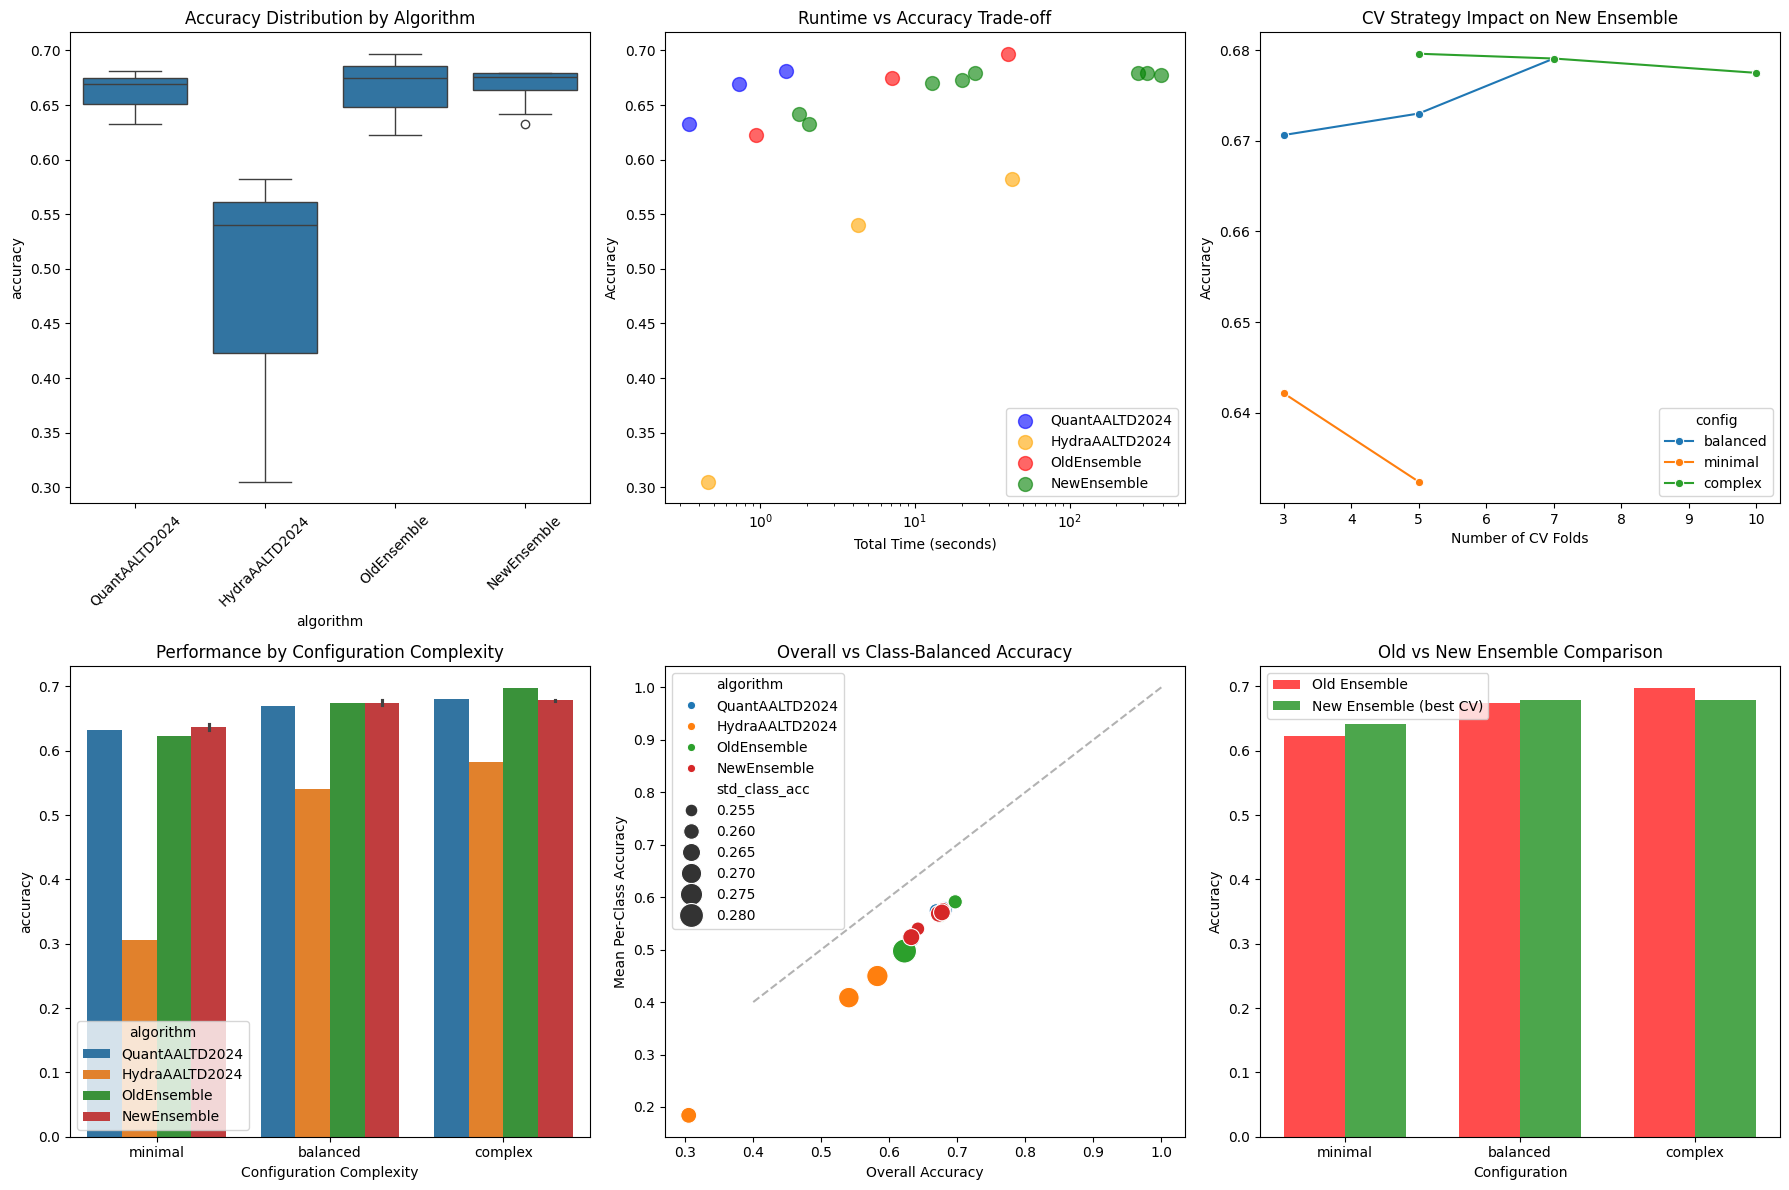

📊 Visualizations generated!


In [9]:
# Visualization of results (if matplotlib available)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if len(successful_df) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Accuracy by algorithm
        ax = axes[0, 0]
        sns.boxplot(data=successful_df, x='algorithm', y='accuracy', ax=ax)
        ax.set_title('Accuracy Distribution by Algorithm')
        ax.tick_params(axis='x', rotation=45)
        
        # 2. Runtime vs Accuracy trade-off
        ax = axes[0, 1]
        colors = {'QuantAALTD2024': 'blue', 'HydraAALTD2024': 'orange', 
                 'OldEnsemble': 'red', 'NewEnsemble': 'green'}
        for algo in successful_df['algorithm'].unique():
            algo_data = successful_df[successful_df['algorithm'] == algo]
            ax.scatter(algo_data['total_time'], algo_data['accuracy'], 
                      label=algo, color=colors.get(algo, 'gray'), s=100, alpha=0.6)
        ax.set_xlabel('Total Time (seconds)')
        ax.set_ylabel('Accuracy')
        ax.set_title('Runtime vs Accuracy Trade-off')
        ax.legend()
        ax.set_xscale('log')
        
        # 3. CV Strategy Impact (New Ensemble only)
        ax = axes[0, 2]
        new_only = successful_df[successful_df['algorithm'] == 'NewEnsemble']
        if len(new_only) > 0:
            cv_grouped = new_only.groupby(['cv_folds', 'config'])['accuracy'].mean().reset_index()
            sns.lineplot(data=cv_grouped, x='cv_folds', y='accuracy', hue='config', marker='o', ax=ax)
            ax.set_title('CV Strategy Impact on New Ensemble')
            ax.set_xlabel('Number of CV Folds')
            ax.set_ylabel('Accuracy')
        
        # 4. Complexity impact
        ax = axes[1, 0]
        complexity_order = ['minimal', 'balanced', 'complex']
        config_data = successful_df[successful_df['config'].isin(complexity_order)]
        sns.barplot(data=config_data, x='config', y='accuracy', hue='algorithm', ax=ax, order=complexity_order)
        ax.set_title('Performance by Configuration Complexity')
        ax.set_xlabel('Configuration Complexity')
        
        # 5. Class balance performance
        ax = axes[1, 1]
        sns.scatterplot(data=successful_df, x='accuracy', y='mean_class_acc', 
                       hue='algorithm', size='std_class_acc', ax=ax, sizes=(50, 300))
        ax.plot([0.4, 1.0], [0.4, 1.0], 'k--', alpha=0.3)
        ax.set_title('Overall vs Class-Balanced Accuracy')
        ax.set_xlabel('Overall Accuracy')
        ax.set_ylabel('Mean Per-Class Accuracy')
        
        # 6. New vs Old direct comparison
        ax = axes[1, 2]
        comparison_data = []
        for config in successful_df['config'].unique():
            old_acc = successful_df[(successful_df['algorithm'] == 'OldEnsemble') & 
                                   (successful_df['config'] == config)]['accuracy'].values
            new_acc = successful_df[(successful_df['algorithm'] == 'NewEnsemble') & 
                                   (successful_df['config'] == config)]['accuracy'].max()
            if len(old_acc) > 0:
                comparison_data.append({'config': config, 'old': old_acc[0], 'new': new_acc})
        
        if comparison_data:
            comp_df = pd.DataFrame(comparison_data)
            x = np.arange(len(comp_df))
            width = 0.35
            ax.bar(x - width/2, comp_df['old'], width, label='Old Ensemble', color='red', alpha=0.7)
            ax.bar(x + width/2, comp_df['new'], width, label='New Ensemble (best CV)', color='green', alpha=0.7)
            ax.set_xlabel('Configuration')
            ax.set_ylabel('Accuracy')
            ax.set_title('Old vs New Ensemble Comparison')
            ax.set_xticks(x)
            ax.set_xticklabels(comp_df['config'])
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        print("📊 Visualizations generated!")
    
except ImportError:
    print("⚠️ Matplotlib not available, skipping visualizations")

In [10]:
# Export results and create comprehensive report
import os
from datetime import datetime

results_dir = "/Users/urav/code/research/experiments/results"
os.makedirs(results_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = f"{results_dir}/deep_ensemble_comparison_{DATASET_NAME}_{timestamp}.csv"

df.to_csv(results_file, index=False)
print(f"📁 Results saved to: {results_file}")

# Create detailed summary report
summary_file = f"{results_dir}/deep_summary_{DATASET_NAME}_{timestamp}.txt"
with open(summary_file, 'w') as f:
    f.write("DEEP ENSEMBLE COMPARISON REPORT\n")
    f.write("="*50 + "\n\n")
    f.write(f"Dataset: {DATASET_NAME}\n")
    f.write(f"Training: {TRAIN_PCT}%, Testing: {TEST_PCT}%\n")
    f.write(f"Random Seed: {RANDOM_SEED}\n")
    f.write(f"Complexity Levels Tested: {list(CONFIGS.keys())}\n\n")
    
    if len(successful_df) > 0:
        f.write("KEY FINDINGS:\n")
        f.write("-"*30 + "\n")
        
        # Best performers
        best_overall = successful_df.loc[successful_df['accuracy'].idxmax()]
        f.write(f"Best Overall: {best_overall['algorithm']} ")
        f.write(f"({best_overall['config']}) → {best_overall['accuracy']:.4f}\n")
        
        # Algorithm comparison
        for algo in successful_df['algorithm'].unique():
            algo_data = successful_df[successful_df['algorithm'] == algo]
            best = algo_data.loc[algo_data['accuracy'].idxmax()]
            f.write(f"\n{algo}:\n")
            f.write(f"  Best: {best['accuracy']:.4f} ({best['config']})\n")
            if algo == 'NewEnsemble':
                f.write(f"  Best CV: {best['cv_folds']} folds\n")
            f.write(f"  Mean: {algo_data['accuracy'].mean():.4f} ± {algo_data['accuracy'].std():.4f}\n")
        
        # Old vs New comparison
        old_best = successful_df[successful_df['algorithm'] == 'OldEnsemble']['accuracy'].max()
        new_best = successful_df[successful_df['algorithm'] == 'NewEnsemble']['accuracy'].max()
        f.write(f"\nHEAD-TO-HEAD:\n")
        f.write(f"  Old Ensemble: {old_best:.4f}\n")
        f.write(f"  New Ensemble: {new_best:.4f}\n")
        f.write(f"  Difference: {new_best - old_best:+.4f}\n")
        
        # CV strategy insights
        new_data = successful_df[successful_df['algorithm'] == 'NewEnsemble']
        if len(new_data) > 0:
            f.write(f"\nCV STRATEGY INSIGHTS:\n")
            for cv in sorted(new_data['cv_folds'].unique()):
                cv_acc = new_data[new_data['cv_folds'] == cv]['accuracy'].mean()
                f.write(f"  {cv} folds: {cv_acc:.4f} avg accuracy\n")

print(f"📋 Summary report saved to: {summary_file}")

# Final conclusions
print("\n" + "="*80)
print("🎯 KEY TAKEAWAYS:")
print("-"*40)

if len(successful_df) > 0:
    old_max = successful_df[successful_df['algorithm'] == 'OldEnsemble']['accuracy'].max()
    new_max = successful_df[successful_df['algorithm'] == 'NewEnsemble']['accuracy'].max()
    
    if new_max > old_max:
        print(f"✅ New ensemble OUTPERFORMS old by {new_max - old_max:.4f}")
        best_new = successful_df[(successful_df['algorithm'] == 'NewEnsemble') & 
                                 (successful_df['accuracy'] == new_max)].iloc[0]
        print(f"   Best config: {best_new['config']} with CV={best_new['cv_folds']}")
    else:
        print(f"⚠️  Old ensemble still performs better by {old_max - new_max:.4f}")
        print("   BUT: Old ensemble has data leakage!")
        print(f"   New ensemble best: {new_max:.4f} (clean cross-validation)")
    
    # Check if more CV helps
    new_cv_data = successful_df[successful_df['algorithm'] == 'NewEnsemble']
    if len(new_cv_data) > 0:
        cv_correlation = new_cv_data[['cv_folds', 'accuracy']].corr().iloc[0, 1]
        if abs(cv_correlation) > 0.3:
            if cv_correlation > 0:
                print(f"\n📈 More CV folds → better performance (r={cv_correlation:.3f})")
            else:
                print(f"\n📉 Fewer CV folds → better performance (r={cv_correlation:.3f})")
        else:
            print(f"\n🔄 CV fold count has minimal impact (r={cv_correlation:.3f})")

print("\n🎉 Deep ensemble comparison complete!")

📁 Results saved to: /Users/urav/code/research/experiments/results/deep_ensemble_comparison_Pedestrian_20250922_222004.csv
📋 Summary report saved to: /Users/urav/code/research/experiments/results/deep_summary_Pedestrian_20250922_222004.txt

🎯 KEY TAKEAWAYS:
----------------------------------------
⚠️  Old ensemble still performs better by 0.0174
   BUT: Old ensemble has data leakage!
   New ensemble best: 0.6796 (clean cross-validation)

📈 More CV folds → better performance (r=0.478)

🎉 Deep ensemble comparison complete!
